In [1]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.4.0'
spark_version = 'spark-3.4.4'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [2]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

In [3]:
# Read in data from S3 Bucket
import pandas as pd
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("NYC Taxi Data Analysis") \
    .getOrCreate()

# URL of the CSV file
data_url = "https://project4-nyctaxi.s3.us-east-1.amazonaws.com/train.csv"

# Download the file using Pandas
local_file = "train.csv"
pd.read_csv(data_url).to_csv(local_file, index=False)

# Read the local file into a Spark DataFrame
df = spark.read.csv(local_file, header=True, inferSchema=True)

# Show the DataFrame
df.show()

+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|
+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+
|id2875421|        2|2016-03-14 17:24:55|2016-03-14 17:32:30|              1|-73.98215484619139| 40.76793670654297|-73.96463012695312|40.765602111816406|                 N|          455|
|id2377394|        1|2016-06-12 00:43:35|2016-06-12 00:54:38|              1|-73.98041534423827|40.738563537597656|-73.99948120117188|40.731151580810554|                 N|          663|
|id3858529|        2|2016-01-19 11:35:24|2016-01-19 12:10:48|    

In [4]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


In [5]:
from pyspark.sql.functions import col, hour, dayofmonth, dayofweek, to_timestamp

# Convert pickup_datetime to a timestamp
df = df.withColumn('pickup_datetime', to_timestamp(col('pickup_datetime')))

# Extract time-based features
df = df.withColumn('pickup_hour', hour(col('pickup_datetime')))
df = df.withColumn('pickup_day', dayofmonth(col('pickup_datetime')))
df = df.withColumn('pickup_weekday', dayofweek(col('pickup_datetime')))

# Show the updated DataFrame
df.show()


+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+-----------+----------+--------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|pickup_hour|pickup_day|pickup_weekday|
+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+-----------+----------+--------------+
|id2875421|        2|2016-03-14 17:24:55|2016-03-14 17:32:30|              1|-73.98215484619139| 40.76793670654297|-73.96463012695312|40.765602111816406|                 N|          455|         17|        14|             2|
|id2377394|        1|2016-06-12 00:43:35|2016-06-12 00:54:38|              1|-73.98041534423827|40.7

In [6]:
# Define features (X) and target (y)
X = df.drop('trip_duration')
y = df.select('trip_duration')


In [7]:
# Split the dataset into training and testing sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

In [8]:
from pyspark.sql.functions import col
from pyspark.sql.types import TimestampType


In [9]:
train_data = train_data.withColumn('pickup_datetime', col('pickup_datetime').cast('timestamp'))
test_data = test_data.withColumn('pickup_datetime', col('pickup_datetime').cast('timestamp'))


In [10]:
from pyspark.ml.regression import RandomForestRegressor

# Define the Random Forest model with the correct parameters
rf = RandomForestRegressor(featuresCol='features', labelCol='trip_duration', numTrees=100)

In [11]:
train_data.printSchema()


root
 |-- id: string (nullable = true)
 |-- vendor_id: integer (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- trip_duration: integer (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- pickup_day: integer (nullable = true)
 |-- pickup_weekday: integer (nullable = true)



In [12]:
from pyspark.ml.feature import VectorAssembler

# Assemble features
feature_columns = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
                   'dropoff_longitude', 'pickup_hour', 'pickup_day', 'pickup_weekday']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

In [13]:
from pyspark.sql.functions import col

# List of feature columns to cast
numeric_columns = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']


In [14]:
# Cast each column to double
for column in numeric_columns:
    train_data = train_data.withColumn(column, col(column).cast('double'))
    test_data = test_data.withColumn(column, col(column).cast('double'))

In [15]:
# Transform the train and test datasets
train_data = assembler.transform(train_data).select('features', 'trip_duration')
test_data = assembler.transform(test_data).select('features', 'trip_duration')

In [16]:
train_data.select('features', 'trip_duration').show(5, truncate=False)


+------------------------------------------------------------------------------------------+-------------+
|features                                                                                  |trip_duration|
+------------------------------------------------------------------------------------------+-------------+
|[40.72476196289063,-74.00962829589844,40.71548461914063,-74.015869140625,9.0,15.0,4.0]    |303          |
|[40.765926361083984,-73.96918487548828,40.76223373413086,-73.98165893554686,22.0,4.0,6.0] |256          |
|[40.780948638916016,-73.98369598388672,40.764175415039055,-73.95437622070312,9.0,17.0,3.0]|1939         |
|[40.742225646972656,-74.00420379638672,40.75182342529297,-73.9945068359375,3.0,13.0,1.0]  |297          |
|[40.817779541015625,-73.9420623779297,40.64738845825195,-73.7889175415039,4.0,28.0,7.0]   |1620         |
+------------------------------------------------------------------------------------------+-------------+
only showing top 5 rows



In [17]:
from pyspark.sql.functions import col

# Cast trip_duration as double
train_data = train_data.withColumn('trip_duration', col('trip_duration').cast('double'))
test_data = test_data.withColumn('trip_duration', col('trip_duration').cast('double'))

In [18]:
model = rf.fit(train_data)


In [19]:
# Make Predictions
predictions = model.transform(test_data)

In [20]:
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluate the Model
evaluator = RegressionEvaluator(labelCol='trip_duration', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})

In [21]:
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")


Root Mean Squared Error (RMSE): 3119.1276756613697
Mean Absolute Error (MAE): 505.86142623454435


In [22]:
import matplotlib.pyplot as plt

# Convert predictions to pandas for visualization
predictions_pandas = predictions.select('trip_duration', 'prediction').toPandas()
predictions_pandas.head()

,trip_duration,prediction
0,427.0,813.353015
1,225.0,818.663492
2,564.0,819.469303
3,2531.0,1872.404963
4,319.0,821.748299


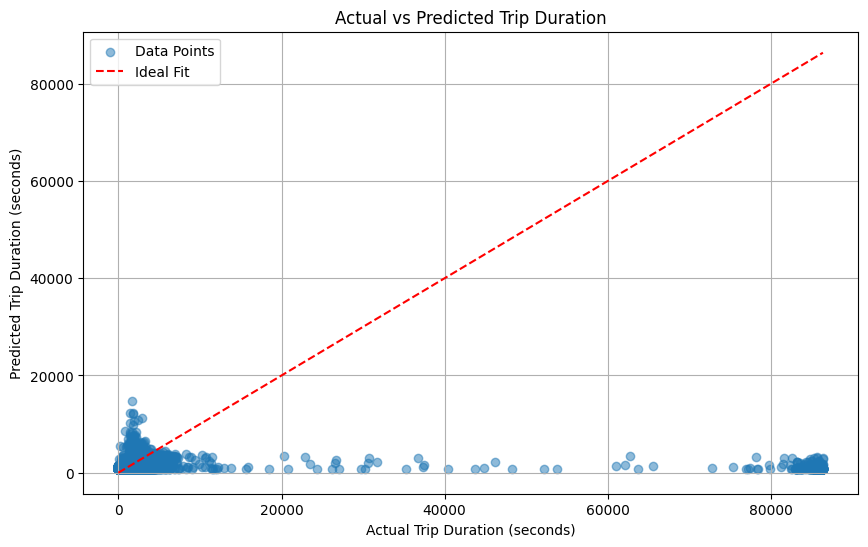

In [23]:
# Plot Actual vs. Predicted trip duration
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pandas['trip_duration'], predictions_pandas['prediction'], alpha=0.5, label='Data Points')
plt.plot([0, predictions_pandas['trip_duration'].max()],
         [0, predictions_pandas['trip_duration'].max()], color='red', linestyle='--', label='Ideal Fit')
plt.title('Actual vs Predicted Trip Duration')
plt.xlabel('Actual Trip Duration (seconds)')
plt.ylabel('Predicted Trip Duration (seconds)')
plt.legend()
plt.grid()
plt.show()

In [24]:
from pyspark.ml.regression import LinearRegression

# Define the Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol='trip_duration')

In [25]:
# Train the model
linear_model = lr.fit(train_data)

In [26]:
# Make predictions
linear_predictions = linear_model.transform(test_data)

In [27]:
# Evaluate the model
lr_rmse = evaluator.evaluate(linear_predictions)
lr_mae = evaluator.evaluate(linear_predictions, {evaluator.metricName: "mae"})

print(f"Linear Regression - Root Mean Squared Error (RMSE): {lr_rmse}")
print(f"Linear Regression - Mean Absolute Error (MAE): {lr_mae}")

Linear Regression - Root Mean Squared Error (RMSE): 3147.113573166716
Linear Regression - Mean Absolute Error (MAE): 592.9455930033218


In [28]:
linear_predictions.show()


+--------------------+-------------+------------------+
|            features|trip_duration|        prediction|
+--------------------+-------------+------------------+
|[40.7637863159179...|        427.0| 940.7123599908664|
|[40.7304382324218...|        225.0| 991.0200288758497|
|[40.7422790527343...|        564.0| 985.2501915977336|
|[40.7617492675781...|       2531.0|1024.8802439430729|
|[40.7498016357421...|        319.0| 916.5044748937944|
|[40.7627754211425...|       1084.0| 876.8405412035645|
|[40.7459564208984...|        443.0| 978.2553961175727|
|[40.7359199523925...|       1792.0| 943.1352065388928|
|[40.7404937744140...|        283.0|  891.547353283444|
|[40.7552490234375...|        844.0| 858.8546783927013|
|[40.7805709838867...|        282.0| 883.7724301655544|
|[40.7388381958007...|        313.0| 990.9939815672697|
|[40.7369041442871...|       1096.0|1020.1594477623003|
|[40.7702102661132...|       1643.0|  738.992764371098|
|[40.7288513183593...|        146.0|1043.6748038

In [29]:
# Convert Spark DataFrame to Pandas for easy manipulation
linear_predictions_pandas = linear_predictions.select("trip_duration", "prediction").toPandas()

In [30]:
# Extract actual and predicted values
actual = linear_predictions_pandas["trip_duration"]
predicted = linear_predictions_pandas["prediction"]

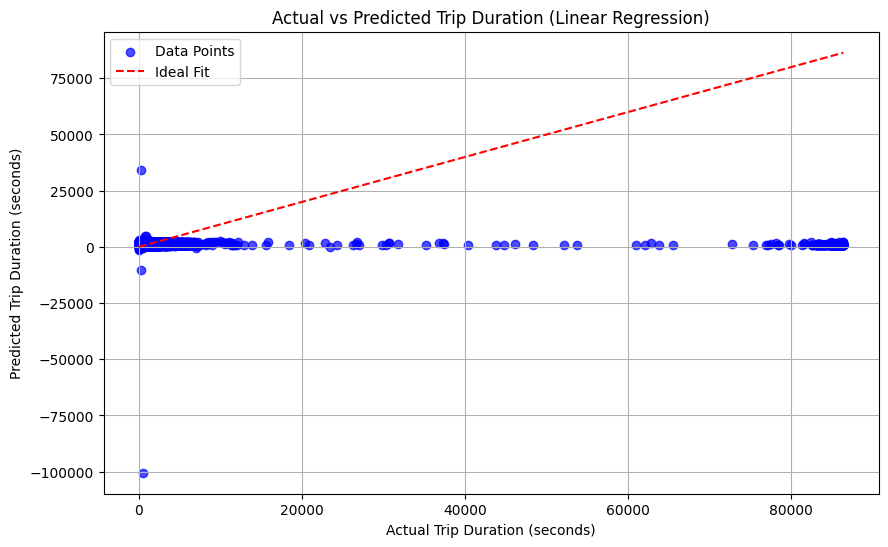

In [31]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(actual, predicted, label="Data Points", alpha=0.7, color='blue')
plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], color="red", linestyle="--", label="Ideal Fit")

plt.xlabel("Actual Trip Duration (seconds)")
plt.ylabel("Predicted Trip Duration (seconds)")
plt.title("Actual vs Predicted Trip Duration (Linear Regression)")
plt.legend()
plt.grid(True)
plt.show()